In [11]:
# Import basic
import pandas as pd
import numpy as np
import cv2
# Import plots
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# from keras.models import Sequential
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger

from importlib import reload
import visualization
import transformations
import model
import loader

from visualization import plots

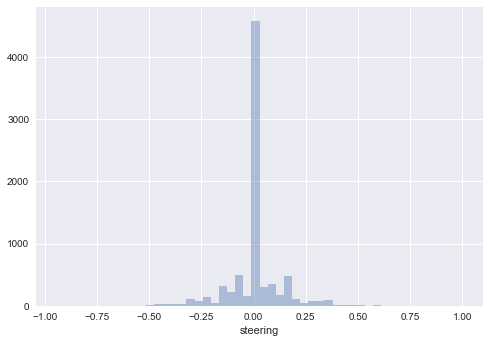

In [2]:
model_file = '.hdf5_checkpoints-13/model.json'
model_weights = '.hdf5_checkpoints-13/model.h5'
master = 'data/driving_log.csv'
data = pd.read_csv(master)
data = data.rename_axis(None)
data = shuffle(data)
sns.distplot(data['steering'], kde=False)
sns.plt.show()

In [3]:
train, validation = train_test_split(data, test_size=0.2, random_state=0)
print('TRAIN:', len(train))
print('VALIDATION:', len(validation))

BATCH_SIZE = 128

def generate_arrays_from_dataframe(data):
    while True:
        for offset in range(0, len(data), BATCH_SIZE):
            offset = 0
            batch = data[offset:offset+BATCH_SIZE]
            y = batch['steering'].values
            x = np.array([ cv2.imread('data/{}'.format(basename)) for basename in batch['center'].values])
            yield (x, y)

TRAIN: 6428
VALIDATION: 1608


In [4]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model
import numpy as np

from keras.models import model_from_json
with open(model_file, 'r') as f:
    model = model_from_json(f.read())

model.compile("adam", "mse")
model.load_weights(model_weights)

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 66, 200, 3)    0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        input_1[0][0]                    
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 31, 98, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       elu_1[0][0]                      
___________________________________________________________________________________________

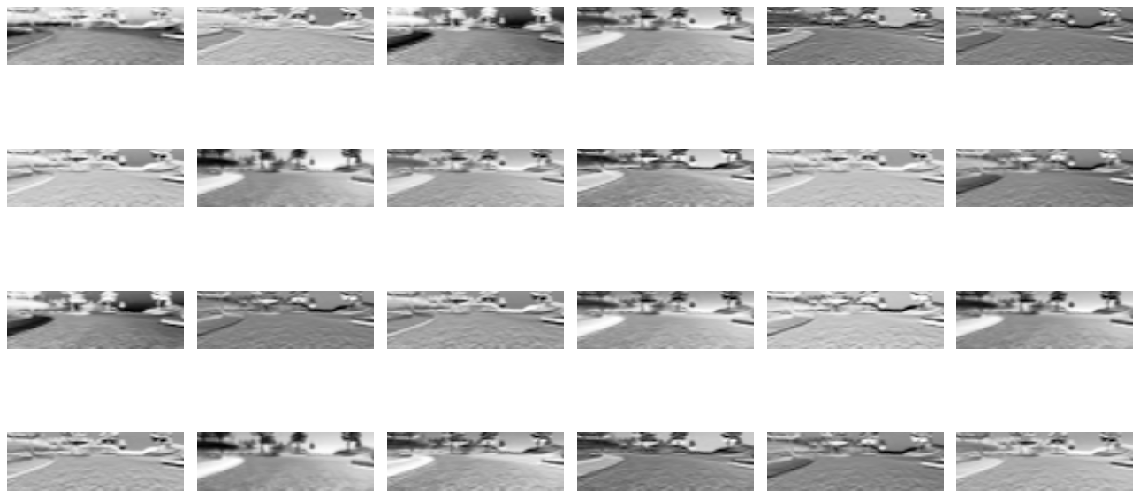

In [5]:
import visualization
reload(visualization)
from visualization import plots
from loader import ReadImg
from transformations import Preproc

img_path = 'data/IMG/center_2016_12_01_13_42_07_691.jpg'
org_img = ReadImg(img_path)
img = Preproc(org_img)

first_ELU = Model(input=model.layers[0].input, output=model.layers[2].output)
first_ELU.compile(optimizer='adam', loss='mse')

out = first_ELU.predict(np.reshape(img, (1, 66, 200, 3)))
feats = [cv2.resize(out[0, :, :, i], (200, 66)) for i in range(out.shape[-1])]
plots(feats, 6, 6, figsize=(16, 12), grid=False)

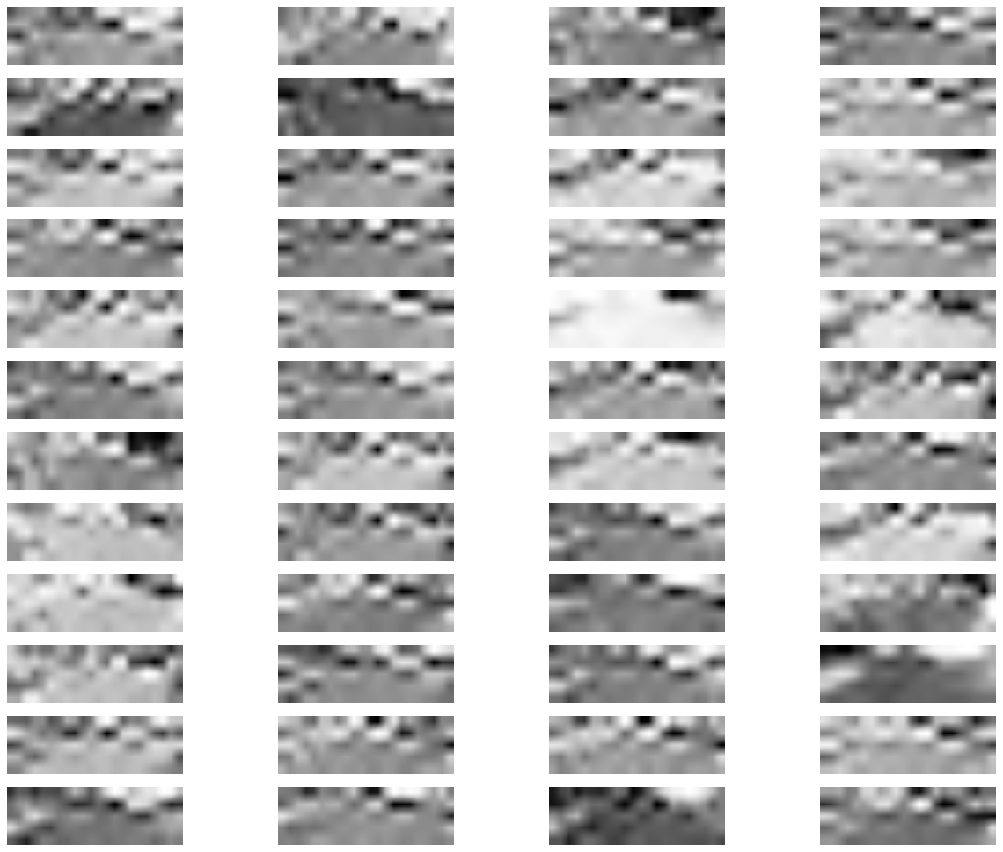

In [6]:
second_ELU = Model(input=model.layers[0].input, output=model.layers[6].output)
second_ELU.compile(optimizer='adam', loss='mse')

out = second_ELU.predict(np.reshape(img, (1, 66, 200, 3)))
feats = [cv2.resize(out[0, :, :, i], (200, 66)) for i in range(out.shape[-1])]
col = 4
row = out.shape[-1]/col
plots(feats, row, col, figsize=(16, 12), grid=False)

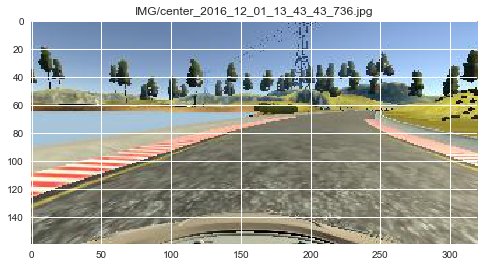

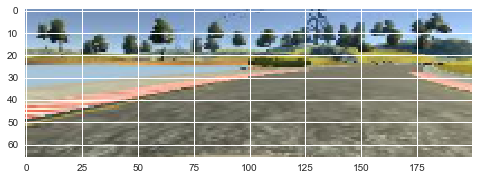

IMG/center_2016_12_01_13_43_43_736.jpg


In [15]:
reload(transformations)
reload(loader)
import matplotlib.pyplot as plt
from keras.models import model_from_json
from transformations import Preproc
from loader import ReadImg

std = np.std(train['steering'])
sample = train[train['steering'] > +3*std].sample()
basename = sample['center'].item()
org_img = ReadImg('data/{}'.format(basename))
img = Preproc(org_img)
plt.subplots(1, 1)
plt.title(basename)
plt.imshow(org_img)
plt.subplots(1, 1)
plt.imshow(img)
plt.show()
print(basename)
# img_input = np.expand_dims(img, axis=0)
# img = cv2.equalizeHist(img)
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(3,3))
# img = clahe.apply(img)
# plt.subplots(1, 1)
# plt.imshow(img)
# plt.show()
# pred = model.predict(img_input)
# print(sample['steering'].item(), pred, sample['center'].item())

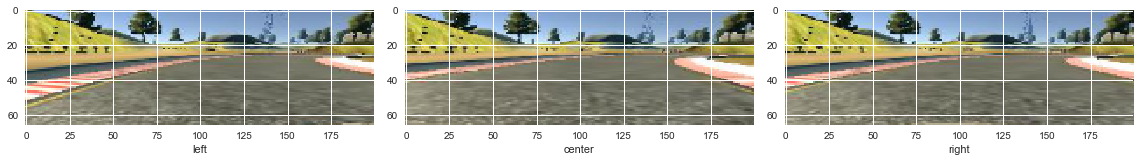

In [19]:
import loader
import transformations
reload(transformations)

from transformations import RandomBrightness, Preproc
reload(loader)
from loader import ReadImg
sample = train[train['steering'] > +3*std].sample()
left = Preproc(ReadImg('data/{}'.format(sample['left'].item().strip())))
center = Preproc(ReadImg('data/{}'.format(sample['center'].item().strip())))
right = Preproc(ReadImg('data/{}'.format(sample['right'].item().strip())))
images = [left, right, center]    
plots(images, 1, 3, figsize=(16, 12),labels=['left', 'center', 'right'])

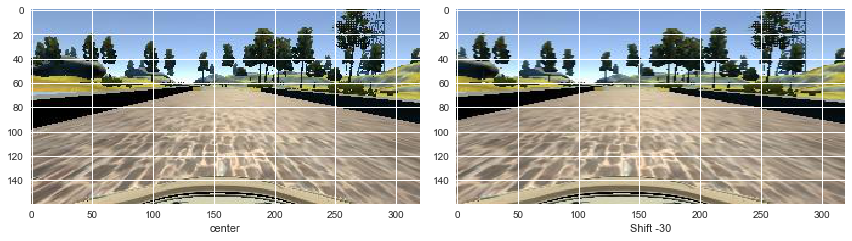

In [46]:
reload(transformations)
reload(visualization)
from visualization import plots
from transformations import Rotate, Translate, Crop, Resize, Shift
img_path = 'data/IMG/center_2016_12_01_13_30_48_287.jpg'
img = ReadImg(img_path)
plots([img, Shift(img, -30)], 1, 2, figsize=(12, 9), labels=['center', 'Shift -30'], grid=True)

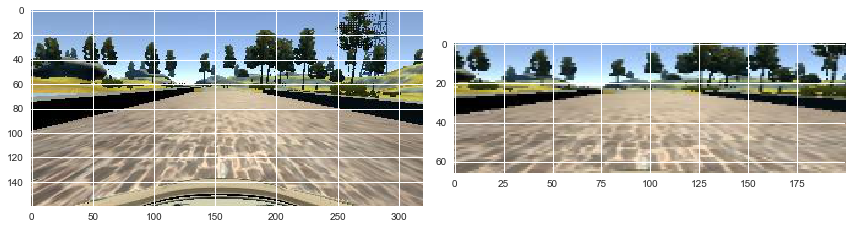

In [21]:
img_path = 'data/IMG/center_2016_12_01_13_30_48_287.jpg'
org_img = ReadImg(img_path)
img = Preproc(org_img)
plots([org_img, img], 1, 2, figsize=(12, 9))

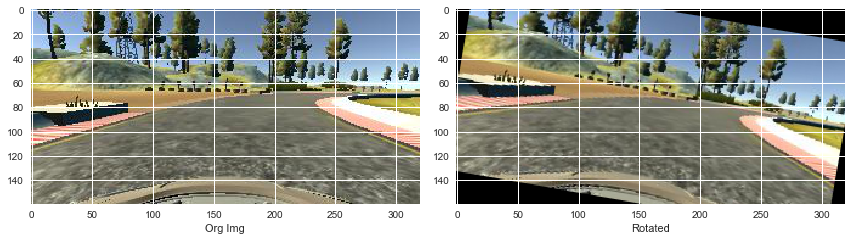

In [47]:
rot = Rotate(angle=-10)
img = rot.apply(org_img)
plots([org_img, img], 1, 2, figsize=(12, 9), labels=['Org Img', 'Rotated'])

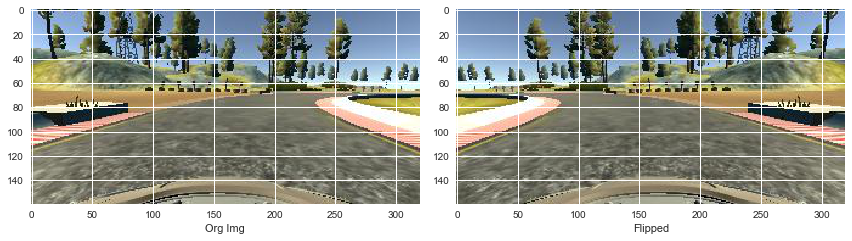

In [48]:
from transformations import Flip
img_path = 'data/IMG/center_2016_12_01_13_40_09_658.jpg'
org_img = ReadImg(img_path)
flip = Flip()
img = flip.apply(org_img)
plots([org_img, img], 1, 2, figsize=(12, 9),labels=['Org Img', 'Flipped'])

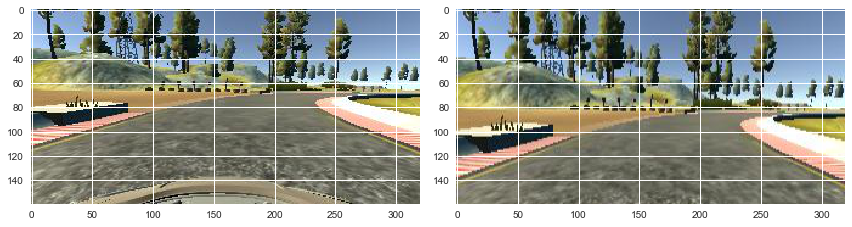

In [26]:
# from transformations import Shift

def Shift(_img, by_x=0, by_y=0):
    height = _img.shape[0]
    width = _img.shape[1]
    img = Translate(by_x=by_x, by_y=by_y).apply(_img)
    if by_x >= 0 and by_y > 0:
        img = Crop(by_x, width, by_y, height).apply(img)
    elif by_x >= 0 and by_y < 0:
        img = Crop(by_x, width, 0, height+by_y).apply(img)
    elif by_x < 0 and by_y < 0:
        img = Crop(0, width + by_x, 0, height + by_y).apply(img)
    elif by_x < 0 and by_y > 0:
        img = Crop(0, width + by_x, by_y, height).apply(img)
    img = Resize(width, height).apply(img)
    return img

org_img = ReadImg(img_path)
img = Shift(org_img, 0, +30)
# img = Translate(by_x=0, by_y=10).apply(org_img)
plots([org_img, img], 1, 2, figsize=(12, 9))

In [11]:
df = train[train['steering']<-2*std].sample(5, replace=True)
print(df.shape)
df.append(train[train['steering']<2*std].sample(5, replace=True))
print(df.shape)
df = df.append(train[train['steering']<2*std].sample(5, replace=True))
print(df.shape)

(5, 7)
(5, 7)
(10, 7)


0.5784606


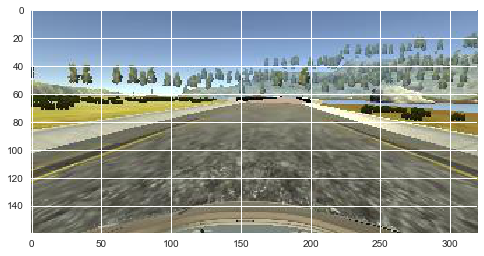

In [12]:
sample = train[train['steering'] > +3*std].sample(1)
basefile = sample['center'].item().strip()
img_path = 'data/{}'.format(basefile)
org_img = ReadImg(img_path)
print(sample['steering'].item())
plt.imshow(org_img)
plt.show()

0.598429556054164


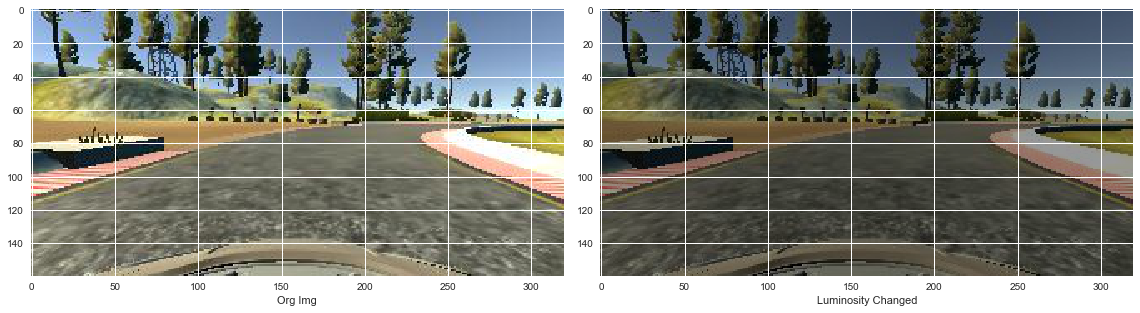

In [50]:
from transformations import RGB2HSV

trans = RGB2HSV()
img = trans.apply(org_img)
# print(img[:, :, 2])
dim = np.random.uniform()
print(dim)
img[:, :, 2] = img[:, :, 2] * dim
# print
# print(img[:, :, 2])
img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
# plt.imshow(img)
# plt.show()
plots([org_img, img], 1, 2, figsize=(16, 12), labels=['Org Img', 'Luminosity Changed'])

In [40]:
sample = train[train['steering'] < +2*std].sample()
sample2 = train[train['steering'] < +2*std].sample()
sample = sample.append(sample2)

sample

,center,left,right,steering,throttle,brake,speed
4795,IMG/center_2016_12_01_13_41_13_159.jpg,IMG/left_2016_12_01_13_41_13_159.jpg,IMG/right_2016_12_01_13_41_13_159.jpg,-0.145206,0.985533,0.0,30.18496
6209,IMG/center_2016_12_01_13_43_36_546.jpg,IMG/left_2016_12_01_13_43_36_546.jpg,IMG/right_2016_12_01_13_43_36_546.jpg,-0.116723,0.985533,0.0,30.18623


In [107]:
sample['steering'].values

array([ 0.,  0.])

In [108]:
np.random.normal(0, 0.0001, 10000)
# zero = train[train['steering'] == 0]
# zero['steering'] = np.random.choice([np.random.normal(0, 0.0001)])
train.head()

,center,left,right,steering,throttle,brake,speed,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36
8421,IMG/center_2017_01_28_21_04_45_005.jpg,NaN,NaN,-0.450000,0.400000,0.0,30.0292,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9901,IMG/center_2017_01_28_21_09_33_299.jpg,NaN,NaN,-0.266667,0.400000,0.0,30.02871,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8822,IMG/center_2017_01_28_21_07_04_922.jpg,NaN,NaN,0.000000,0.000000,0.0,4.515845,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6558,IMG/center_2016_12_01_13_44_11_946.jpg,IMG/left_2016_12_01_13_44_11_946.jpg,IMG/right_2016_12_01_13_44_11_946.jpg,0.000000,0.985533,0.0,30.18663,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12542,IMG/center_2017_01_29_02_44_32_952.jpg,NaN,NaN,0.000000,0.400000,0.0,13.53091,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


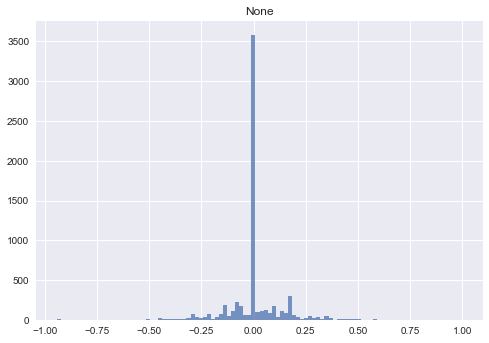

In [54]:
reload(visualization)
from visualization import hist
hist(train, 'steering')

300
2924
3224


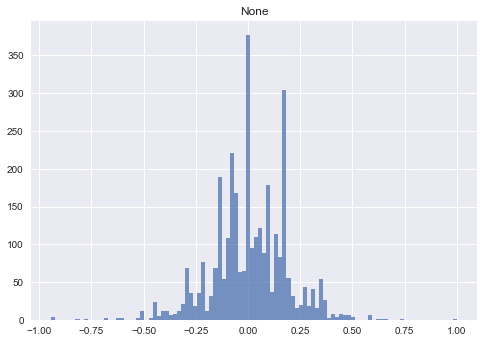

In [57]:
df = train.dropna(axis=0)
zeros = df.where(df['steering'] == 0).dropna(axis=0).sample(300)
non_zeros = df.where(df['steering'] != 0).dropna(axis=0)
df = zeros.append(non_zeros)

print(len(zeros))
print(len(non_zeros))
print(len(df))

hist(df, 'steering')

In [47]:
print(train['steering'].std())

0.129437448412


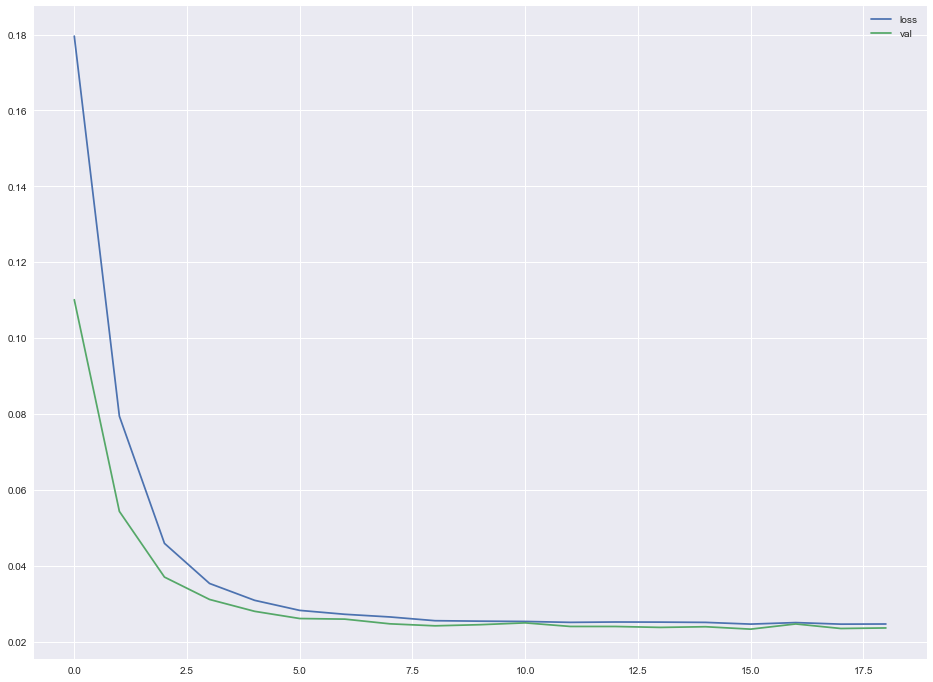

In [61]:
df = pd.read_csv('.hdf5_checkpoints-13/history.csv')
plt.figure(figsize=(16,12))
plt.plot(df['epoch'], df['loss'])
plt.plot(df['epoch'], df['val_loss'])
plt.legend(['loss', 'val'], loc='upper right')
plt.show()

In [62]:
df

,epoch,loss,val_loss
0,0,0.179583,0.110115
1,1,0.079442,0.054345
2,2,0.045917,0.037031
3,3,0.035349,0.031134
4,4,0.030905,0.028008
5,5,0.028254,0.026111
6,6,0.027227,0.025953
7,7,0.026525,0.024713
8,8,0.025537,0.024187
9,9,0.025416,0.024486
